In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

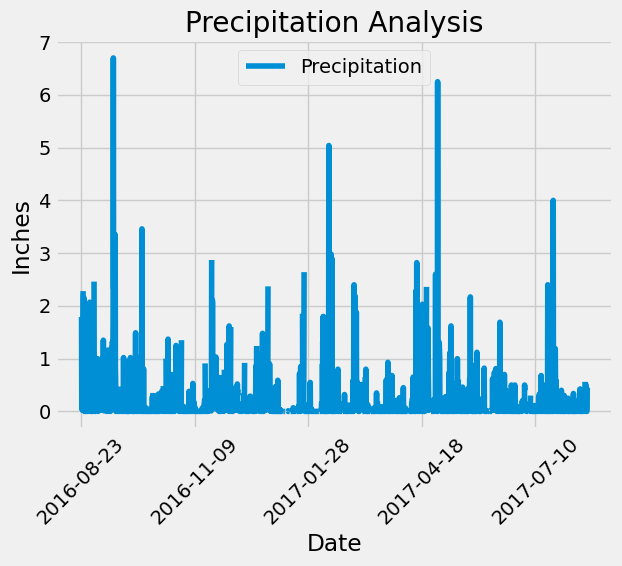

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Starting from the most recent data point in the database
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set
one_year_ago = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', title="Precipitation Analysis")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = precipitation_df.describe()
precipitation_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations_query = session.query(func.count(Station.station)).all()
print(f"Total number of stations: {total_stations_query}")

Total number of stations: [(9,)]


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations_query = session.query(Measurement.station, func.count(Measurement.station).label('observation_count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

most_active_stations = most_active_stations_query.all()

# List the stations and their counts in descending order
print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Observations: {count}")

Most Active Stations:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
most_active_station_id = most_active_stations[0][0]

temperature_stats_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id)

temperature_stats = temperature_stats_query.first()

min_temp, max_temp, avg_temp = temperature_stats
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


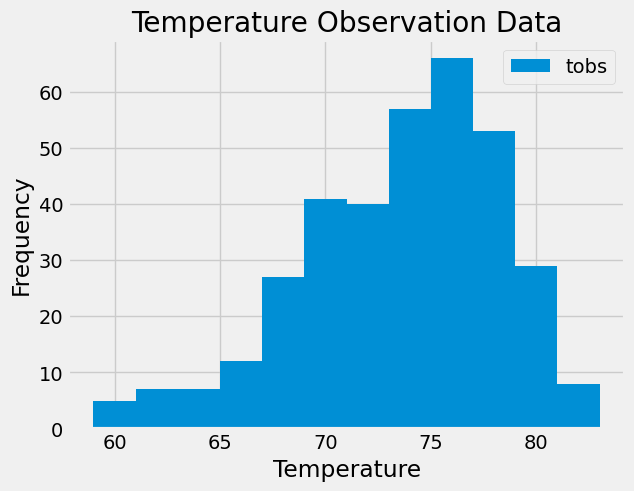

In [15]:
# Using the most active station id, query the last 12 months of temperature observation data for this station
tobs_data_query = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id).filter(Measurement.date >= one_year_ago)

tobs_data = [result[0] for result in tobs_data_query.all()]

# Plot the results as a histogram
plt.hist(tobs_data, bins=12, label='tobs')
plt.title("Temperature Observation Data")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()